In [1]:
!wget -O CALTECH.zip https://zenodo.org/record/4126613/files/CALTECH.zip?download=1

--2023-02-17 06:15:26--  https://zenodo.org/record/4126613/files/CALTECH.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3808782 (3.6M) [application/octet-stream]
Saving to: ‘CALTECH.zip’

CALTECH.zip         100%[===================>]   3.63M   645KB/s    in 5.8s    

2023-02-17 06:15:33 (641 KB/s) - ‘CALTECH.zip’ saved [3808782/3808782]



In [2]:
!unzip CALTECH.zip

Archive:  CALTECH.zip
   creating: CALTECH/
   creating: CALTECH/CALTECH_Annotations/
   creating: CALTECH/CALTECH_Annotations/butterfly/
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0001.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0003.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0004.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0005.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0006.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0007.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0008.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0009.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0010.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0011.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotation_0012.mat  
  inflating: CALTECH/CALTECH_Annotations/butterfly/annotati

In [3]:
import scipy.io
import os
import pandas as pd
import cv2

In [44]:
mat = scipy.io.loadmat('/content/CALTECH/CALTECH_Annotations/butterfly/annotation_0001.mat')

In [45]:
tuple(map(tuple, mat['box_coord']))[0]

(11, 188, 3, 284)

In [46]:
mat['box_coord']

array([[ 11, 188,   3, 284]], dtype=uint16)

In [4]:
def extract_mat_contents(annot_directory, image_dir):
         
        mat = scipy.io.loadmat(annot_directory)
        height, width = cv2.imread(image_dir).shape[:2]
        x1, y2, y1, x2 = tuple(map(tuple, mat['box_coord']))[0]
        class_name = image_dir.split('/')[2]
        filename = '/'.join(image_dir.split('/')[-2:])

        return filename,  width, height, class_name, x1,y1,x2,y2


In [5]:
def mat_to_pd(annot_directory, image_directory, classes_folders):
 
  mat_list = []
  for class_folder in classes_folders:
 
    image_dir = os.path.join(image_directory, class_folder)
    annot_dir = os.path.join(annot_directory, class_folder) 
 
    mat_files = sorted(os.listdir(annot_dir))
    img_files = sorted(os.listdir(image_dir))

    for mat, image_file in zip(mat_files, img_files):
       
      mat_path = os.path.join(annot_dir, mat)
 
      img_path = os.path.join(image_dir, image_file)

      value = extract_mat_contents(mat_path, img_path)
 
      mat_list.append(value)
 
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 
                 'xmax', 'ymax']
 
  mat_df = pd.DataFrame(mat_list, columns=column_name)
 
  return mat_df
 


In [6]:
classes_list = sorted(['butterfly',  'cougar_face', 'elephant'])

In [8]:
value = extract_mat_contents('/content/CALTECH/CALTECH_Annotations/butterfly/annotation_0001.mat', '/content/CALTECH/CALTECH_Dataset/butterfly/image_0001.jpg')

In [9]:
image_directory = 'CALTECH/CALTECH_Dataset'
annot_directory = 'CALTECH/CALTECH_Annotations'

In [10]:
labels_df = mat_to_pd(annot_directory, image_directory, classes_list)

In [11]:
import imgaug.augmenters as iaa

In [12]:
image_augmentations = iaa.SomeOf( 2,
    [                                 
    # Scale the Images
    iaa.Affine(scale=(0.5, 1.5)),
 
    # Rotate the Images
    iaa.Affine(rotate=(-60, 60)),
 
    # Shift the Image
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),
 
    # Flip the Image
    iaa.Fliplr(1),
 
    # Increase or decrease the brightness
    iaa.Multiply((0.5, 1.5)),
 
    # Add Gaussian Blur
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
     
    # Add Gaussian Noise
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
 
])

In [13]:
from imgaug.augmentables.bbs import BoundingBoxesOnImage

In [14]:
# Function to convert bounding box image into DataFrame 
def bounding_boxes_to_df(bounding_boxes_object):
 
    # Convert Bounding Boxes Object to Array
    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
     
    # Convert the array into DataFrame
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array,columns=['xmin', 'ymin', 'xmax', 'ymax'])
     
    # Return the DataFrame
    return df_bounding_boxes

In [15]:
import imageio
import re

In [16]:
def image_aug(df, images_path, aug_images_path, augmentor, multiple = 3):
     
    # Fill this DataFrame with image attributes
    augmentations_df = pd.DataFrame(
        columns=['filename','width','height','class', 'xmin', 'ymin', 'xmax','ymax'])
     
    # Group the data by filenames
    grouped_df = df.groupby('filename')
 
    # Create the directory for all augmentated images
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)
 
    # Create directories for each class of augmentated images
    for folder in df['class'].unique():
      if not os.path.exists(os.path.join(aug_images_path, folder)):
        os.mkdir(os.path.join(aug_images_path, folder))
 
    for i in range(multiple):
       
      # Post Fix we add to the each different augmentation of one image
      image_postfix = str(i)
 
      # Loop to perform the augmentations
      for filename in df['filename'].unique():
 
        augmented_path = os.path.join(aug_images_path, filename)+image_postfix+'.jpg'
 
        # Take one image at a time with its information
        single_image = grouped_df.get_group(filename)
        single_image = single_image.reset_index()
        single_image = single_image.drop(['index'], axis=1)   
         
        # Read the image
        image = imageio.imread(os.path.join(images_path, filename))
 
        # Get bounding box
        bounding_box_array = single_image.drop(['filename', 'width', 'height','class'], axis=1).values
 
        # Give the bounding box to imgaug library
        bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, shape=image.shape)
 
        # Perform random 2 Augmentations
        image_aug, bounding_box_aug = augmentor(image=image, bounding_boxes=bounding_box)
         
        # Discard the the bounding box going out the image completely   
        bounding_box_aug = bounding_box_aug.remove_out_of_image()
 
        # Clip the bounding box that are only partially out of th image
        bounding_box_aug = bounding_box_aug.clip_out_of_image()
 
        # Get rid of the the image if bounding box was discarded  
        if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
            pass
         
        else:
         
          # Create the augmented image file
          imageio.imwrite(augmented_path, image_aug)
 
          # Update the image width and height after augmentation
          info_df = single_image.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
          for index, _ in info_df.iterrows():
              info_df.at[index, 'width'] = image_aug.shape[1]
              info_df.at[index, 'height'] = image_aug.shape[0]
 
          # Add the prefix to each image to differentiate if required
          info_df['filename'] = info_df['filename'].apply(lambda x: x + image_postfix + '.jpg')
 
          # Create the augmented bounding boxes dataframe 
          bounding_box_df = bounding_boxes_to_df(bounding_box_aug)
 
          # Concatenate the filenames, height, width and bounding boxes 
          aug_df = pd.concat([info_df, bounding_box_df], axis=1)
 
          # Add all the information to augmentations_df we initialized above
          augmentations_df = pd.concat([augmentations_df, aug_df])            
       
    # Remove index
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(['index'], axis=1)
 
    # Return the Dataframe
    return augmentations_df
 

In [17]:
augmented_images_df = image_aug(labels_df, image_directory, 'aug_images', image_augmentations)

In [18]:
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('aug.csv')
 
# Check Dataset Size
print('Our total dataset Size before the augmentations was: ', len(labels_df))
print('Our total dataset Size after the augmentations is: ', len(augmented_images_df))


Our total dataset Size before the augmentations was:  218
Our total dataset Size after the augmentations is:  654


In [19]:
def preprocess_dataset(image_folder, classes_list, df, image_size = 300,):
 
  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []
 
  # Get height and width of each image in the datafame
  h = df['height']
  w = df['width']
 
  # Create a copy of the labels in the dataframe
  labels = list(df['class'])
 
  # Create a copy of the bounding box values and also normalize them 
  for x1, y1, x2, y2 in zip(list(df['xmin']/w), list(df['ymin']/h),list(df['xmax']/w), list(df['ymax']/h)):
     
    arr = [x1, y1, x2, y2]
    boxes.append(arr)
 
  # We loop over each class and its labels 
  for class_folder in classes_list:  
 
    # Set our images directory
    image_dir = os.path.join(image_folder, class_folder)
 
    # Annotation and Image files
    img_files = sorted(os.listdir(image_dir))
 
    # Loop over each of the image and its label
    for image_file in img_files:
 
      # Full path Image
      img_path = os.path.join(image_dir, image_file)
 
      # Read the image
      img  = cv2.imread(img_path)
 
      # Resize all images to a fix size
      image = cv2.resize(img, (image_size, image_size))
 
      # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
      # Normalize the image by dividing it by 255.0 
      image = image.astype("float") / 255.0
 
      # Append it to the list of images
      img_list.append(image)
 
  return labels, boxes, img_list

In [20]:
image_size = 224
 
# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset('/content/CALTECH/CALTECH_Dataset', classes_list, labels_df, image_size)

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np

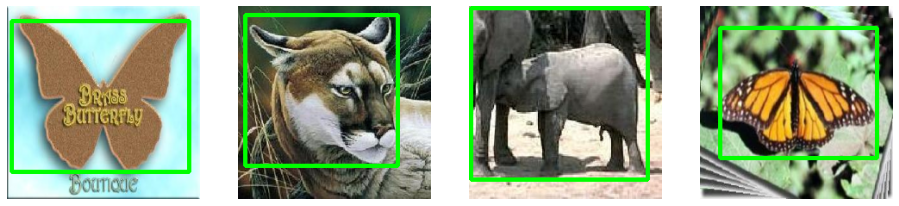

In [22]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));
 
# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 4)
 
for iteration, i in enumerate(random_range, 1):
 
    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i];
 
    # Rescaling the boundig box values to match the image size
    x1 = a1 * image_size
    x2 = a2 * image_size
    y1 = b1 * image_size
    y2 = b2 * image_size
 
    # The image to visualize
    image = img_list[i]
 
    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),(0,255,0),3)
     
    # Clip the values to 0-1 and draw the sample of images
    image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration)
    plt.imshow(image)
    plt.axis('off')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert labels to integers, then one hot encode them
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels)
 
# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, onehot_labels))
random.shuffle(combined_list)
 
# Extract back the contents of each list
img_list, boxes, onehot_labels = zip(*combined_list)
 
print('All Done')

In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert labels to integers, then one hot encode them
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels)
 
# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, onehot_labels))
random.shuffle(combined_list)
 
# Extract back the contents of each list
img_list, boxes, onehot_labels = zip(*combined_list)
 
print('All Done')

All Done


In [24]:
from sklearn.model_selection import train_test_split
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
np.array(onehot_labels), np.array(boxes), test_size = 0.1,random_state = 43)
 
print('Total Training Images: {}, Total Test Images: {}'.format(
    len(train_images), 
    len(val_images)
    ))

Total Training Images: 196, Total Test Images: 22


In [29]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [30]:
base_model = ResNet50(include_top=False, weights='imagenet', pooling='max')

94765736/94765736 [==============================] - 0s 0us/step


In [31]:
# Classification Part
C1 = Dense(100, activation='relu')(base_model.output)
Classification = Dense(3, activation='softmax', name='Classification')(C1)

# Bounding Box Part
R1 = Dense(100, activation='relu')(base_model.output)
Bounding_Box = Dense(4, activation='sigmoid', name='Bounding_Box')(R1)

# Model
model = Model(inputs=base_model.input, outputs=[Classification, Bounding_Box])

In [32]:
from tensorflow.keras.utils import plot_model

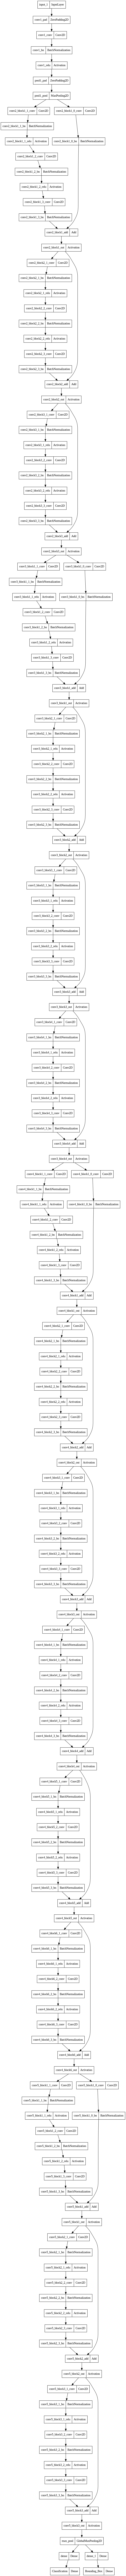

In [33]:
plot_model(model)

In [34]:
manual_loss = {
    'Classification' : 'categorical_crossentropy',
    'Bounding_Box' : 'MSE'
}

metrics = {
    'Classification': 'accuracy',
    'Bounding_Box' : 'MSE'
}

model.compile(loss=manual_loss, optimizer='adam', metrics=metrics)

In [35]:
model.fit(train_images, y={'Classification': train_labels, 'Bounding_Box': train_boxes}, batch_size=16, epochs=2)

Epoch 1/2
13/13 [==============================] - 141s 9s/step - loss: 5.0890 - Classification_loss: 5.0244 - Bounding_Box_loss: 0.0646 - Classification_accuracy: 0.6786 - Bounding_Box_MSE: 0.0646
Epoch 2/2
13/13 [==============================] - 104s 8s/step - loss: 2.8665 - Classification_loss: 2.8212 - Bounding_Box_loss: 0.0453 - Classification_accuracy: 0.6684 - Bounding_Box_MSE: 0.0453


In [36]:
pred = model.predict(val_images)

1/1 [==============================] - 4s 4s/step


In [37]:
pred[0][0] ,pred[1][0]

(array([0.        , 0.99999994, 0.        ], dtype=float32),
 array([0., 0., 1., 1.], dtype=float32))

In [38]:
val_boxes[0]

array([0.32      , 0.03418803, 0.76666667, 0.99145299])

In [39]:
image_size=224
# Bounding box of each image
a1, b1, a2, b2 = val_boxes[0];

# Rescaling the boundig box values to match the image size
x1 = a1 * image_size
x2 = a2 * image_size
y1 = b1 * image_size
y2 = b2 * image_size

cv2.rectangle(val_images[0], (int(x1),int(y1)),
          (int(x2),int(y2)),(0,255,0),3);

In [40]:
import matplotlib.pyplot as plt

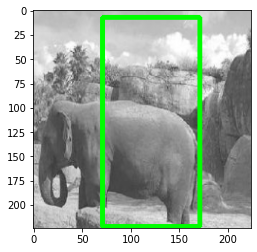

In [41]:
plt.imshow(val_images[0])

In [42]:
image_size=224
# Bounding box of each image
a1, b1, a2, b2 = pred[1][0];

# Rescaling the boundig box values to match the image size
x1 = a1 * image_size
x2 = a2 * image_size
y1 = b1 * image_size
y2 = b2 * image_size

cv2.rectangle(val_images[0], (int(x1),int(y1)),
          (int(x2),int(y2)),(255,0,0),3);

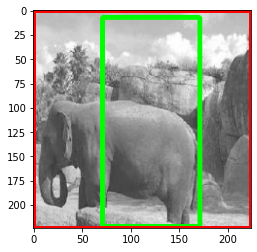

In [43]:
plt.imshow(val_images[0])